In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
#import datasets
import os
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torchvision.models import resnet50

import time

In [2]:
print(torch.__version__)

2.2.2


In [3]:
torch.cuda.is_available()

True

In [34]:
from tensorflow.keras.preprocessing import image_dataset_from_directory  

train_dataset = image_dataset_from_directory('C:/Users/Devi Prasad/Desktop/MyProjects/eye-gender-data/train',
                                             shuffle=True,
                                             batch_size=64,image_size=(224,224))
class_name =  train_dataset.class_names


Found 9220 files belonging to 2 classes.


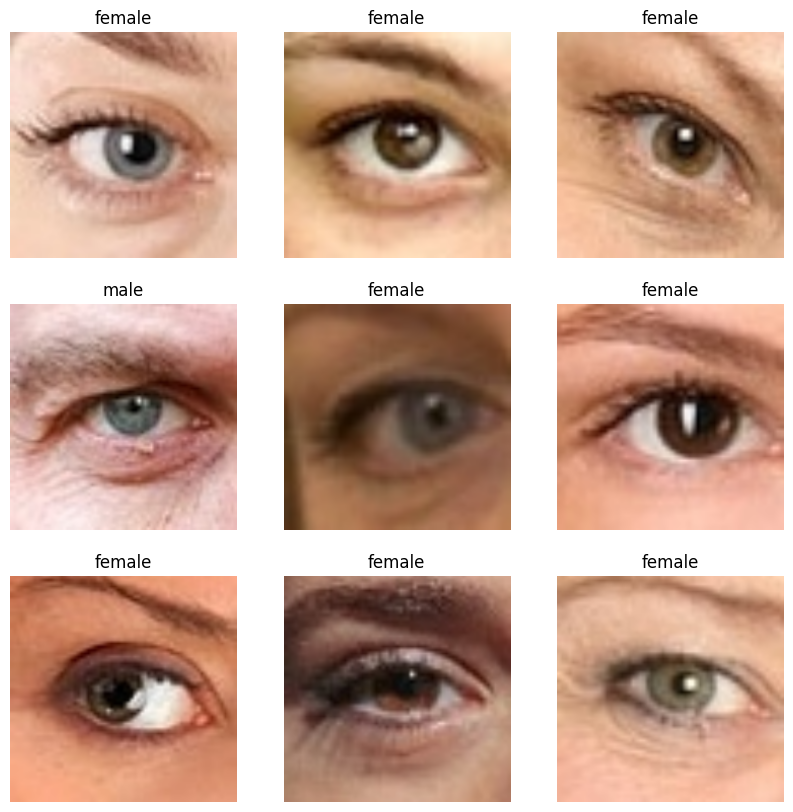

In [36]:
plt.figure(figsize = (10,10))
for image,label in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

In [5]:
data_dir = 'C:/Users/Devi Prasad/Desktop/MyProjects/eye-gender-data/train'

In [6]:
# Define data transformations for data augmentation and normalization
train_transform =  transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [7]:
# Load the train custom dataset
train_data = ImageFolder(root=data_dir, transform=train_transform)

In [8]:
# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

In [9]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [10]:
# Initialize the model
model = models.resnet50(pretrained=True)
print(model)

C:\Users\Devi Prasad\anaconda3\envs\cuda_pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Devi Prasad\anaconda3\envs\cuda_pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# Remove the last layer (fc layer)
num_ftrs = model.fc.in_features

# Add a new fc layer with 2 output classes
model.fc = torch.nn.Linear(num_ftrs, 2)

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training loop
num_epochs = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_corrects.double() / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch 1/2, Train Loss: 0.3431, Val Loss: 0.2834, Val Accuracy: 0.8850


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'eyegender_resnet50_model.pth')

In [17]:
# Load the model
model = models.resnet50()  # Initialize the model
model.fc = torch.nn.Linear(num_ftrs, 2)  # We need to redefine the fc layer before loading the state dict
model.load_state_dict(torch.load(r"C:\Users\Devi Prasad\Desktop\MyProjects\eyegender_resnet50_model.pth"))
# For inference
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
model = model.cuda()

In [11]:
test_data_dir = 'C:/Users/Devi Prasad/Desktop/MyProjects/eye-gender-data/test/New_Folder'

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:
# Load the image and preprocess it
from PIL import Image

image = Image.open(r"C:\Users\Devi Prasad\Desktop\MyProjects\eye-gender-data\test\New_Folder\Image_75.jpg")
image_tensor = test_transform(image).unsqueeze(0).to(device)
print(image_tensor)

tensor([[[[ 1.1872,  1.1872,  1.1358,  ..., -1.7069, -1.7069, -1.7069],
          [ 1.1872,  1.1872,  1.1358,  ..., -1.7069, -1.7069, -1.7069],
          [ 1.1700,  1.1700,  1.1187,  ..., -1.7069, -1.6898, -1.6898],
          ...,
          [ 1.3413,  1.3413,  1.3413,  ...,  1.8550,  1.8550,  1.8550],
          [ 1.3413,  1.3413,  1.3413,  ...,  1.8550,  1.8550,  1.8550],
          [ 1.3413,  1.3413,  1.3413,  ...,  1.8550,  1.8550,  1.8550]],

         [[ 1.2731,  1.2731,  1.2206,  ..., -1.8606, -1.8606, -1.8606],
          [ 1.2731,  1.2731,  1.2206,  ..., -1.8606, -1.8606, -1.8606],
          [ 1.2556,  1.2556,  1.2031,  ..., -1.8606, -1.8431, -1.8431],
          ...,
          [ 1.3606,  1.3606,  1.3606,  ...,  1.8859,  1.8859,  1.8859],
          [ 1.3606,  1.3606,  1.3606,  ...,  1.8859,  1.8859,  1.8859],
          [ 1.3606,  1.3606,  1.3606,  ...,  1.8859,  1.8859,  1.8859]],

         [[ 1.2980,  1.2980,  1.2457,  ..., -1.1944, -1.1944, -1.1944],
          [ 1.2980,  1.2980,  

In [43]:
image_tensor = image_tensor.cuda()

In [44]:
# Set the model in evaluation mode
model.eval()

# Make the prediction
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted = torch.max(outputs, 1)

# Map the predicted index to the class label
class_labels = ['female', 'male']
prediction = class_labels[predicted.item()]

print(f"The image is classified as: {prediction}")

The image is classified as: female


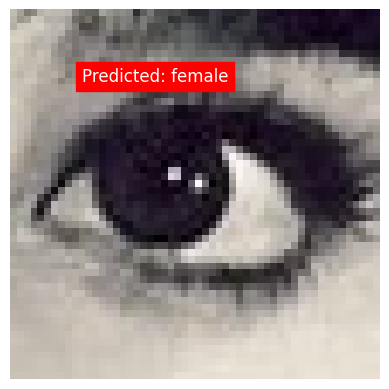

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = Image.open(r"C:\Users\Devi Prasad\Desktop\MyProjects\eye-gender-data\test\New_Folder\Image_75.jpg")
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {prediction}', fontsize=12, color='white', backgroundcolor='red')
plt.show()